In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/silica_opt_insilico/')
from silica_opt_insilico import experiment, execute, data_processing, post_process, contour_animated
from saxs_data_processing import target_comparison
    
import numpy as np
import matplotlib.pyplot as plt

import pickle
import matplotlib.animation as animation
from IPython.display import HTML
import os

## In silico optimization simulation

- objective functions work on volume fractions
- BO works on bounds/0-1


Ground truth:

- Diameter 80nm at [0.007, 0.018, 0.04]
- PDI min at [0.007, 0.025, 0.03]

## Parameters 

### SAXS Data processing parameters

### Experiment 'execution' parameters

In [2]:
# physical experiment bounds

teos_min_vf = 0.005
ammonia_min_vf = 0.005
water_min_vf = 0.005

teos_max_vf = 0.1
ammonia_max_vf = 0.1
water_max_vf = 0.15

noise_frac = 0.5 # what fraction of experimental noise to use

target_r_nm = 40 # particle size target

budget = 100

### Campaign structure 

### 2. Calculate scattering

In [3]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

In [4]:

target_r_angs = target_r_nm*10
target_pdi = 0.1
sld_silica = 8.575
sld_etoh = 9.611

In [5]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

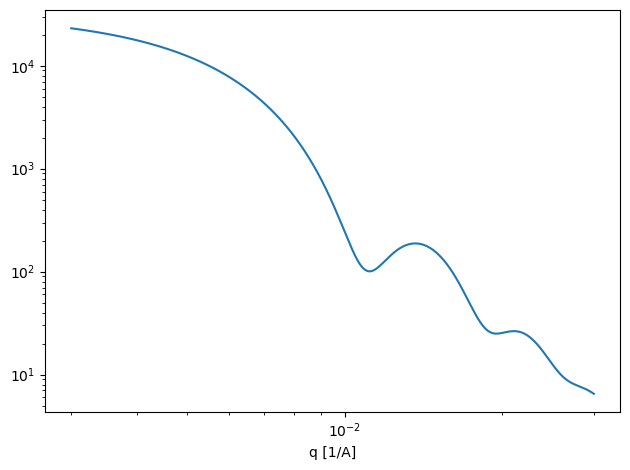

In [6]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')

plt.tight_layout()


In [9]:
trials = {'baseline':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'apdist'
        },
     'noise_1':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':1,
        'characterization':'SAXS',
        'distance':'apdist'
        },
     'rmse':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'rmse'
        },

    }

### 1. Find true minima for this objective function (do once per objective)

In [8]:
true_min = [6.936e-03, 2.021e-02, 4.000e-02] # for original 80nm objective

########################
Results for baseline
Iterations to convergence (threshold 0.05): [48, 47, 51], mean: 48.666666666666664
Closest composition distances observed: [0.04682429, 0.0441143, 0.054170534]
########################
Results for noise_1
Iterations to convergence (threshold 0.05): ['Not converged', 107, 'Not converged'], mean: 123.66666666666667
Closest composition distances observed: [0.08604273, 0.08425917, 0.024478035]
########################
Results for rmse
Iterations to convergence (threshold 0.05): ['Not converged', 'Not converged', 75], mean: 113.0
Closest composition distances observed: [0.024017636, 0.06779071571176494, 0.0412528]


'\n    lower_bounds = params[\'lower_bounds\']\n    upper_bounds = params[\'upper_bounds\']\n    \n    ammonia = np.linspace(lower_bounds[1], upper_bounds[1], n_grid)\n    water = np.linspace(lower_bounds[2], upper_bounds[2], n_grid)\n    teos = np.linspace(lower_bounds[0], upper_bounds[0], n_grid)\n    for i in range(n_replicates):\n        phased = post_process.phase_diagram(data_batches[i], params[\'lower_bounds\'], params[\'upper_bounds\'], q_grid, f\'{trial_name}_replicate_{i}\')\n        plt.savefig(f\'{trial_name}/{trial_name}_replicate_{i}.png\', dpi = 300)#\n\n        anim = contour_animated.ContourAnimation(ammonia, water, teos, Z_ammonia, Z_water, \n                                data_batches[i], best_uuids_list[i], n_batches, true_min, trial_name, n_grid, m_samples, batch_size)\n        \n        anim.save(f"{trial_name}/{trial_name}_replicate_{i}.html", format="html")  # Saves as an HTML file\n\n    # consider convergence on optimizaiton metric used\n    data_complete, da

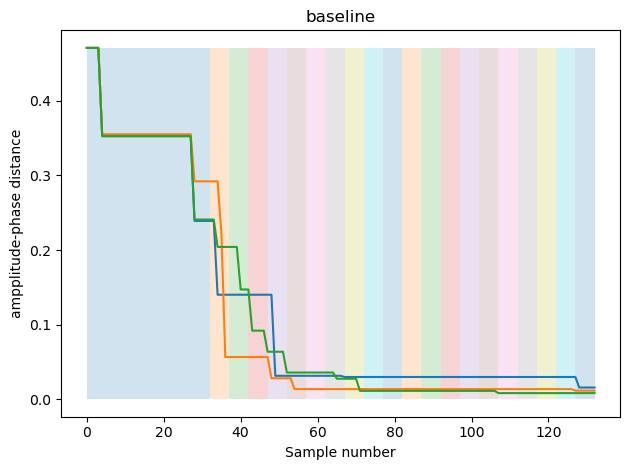

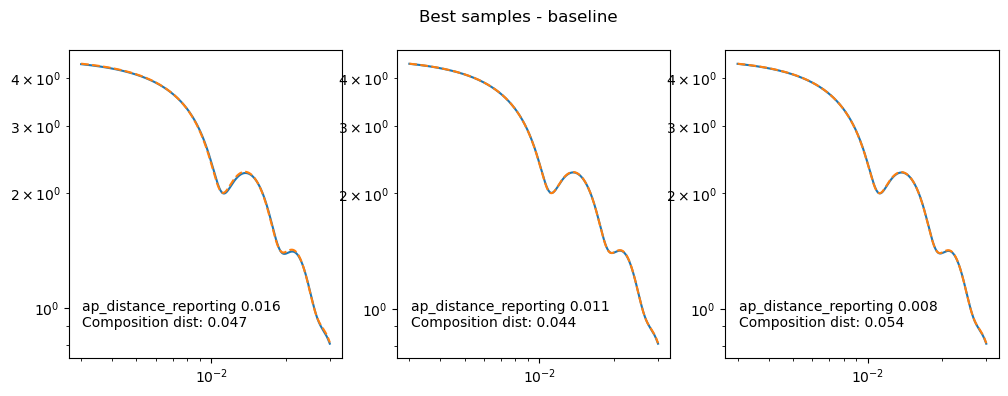

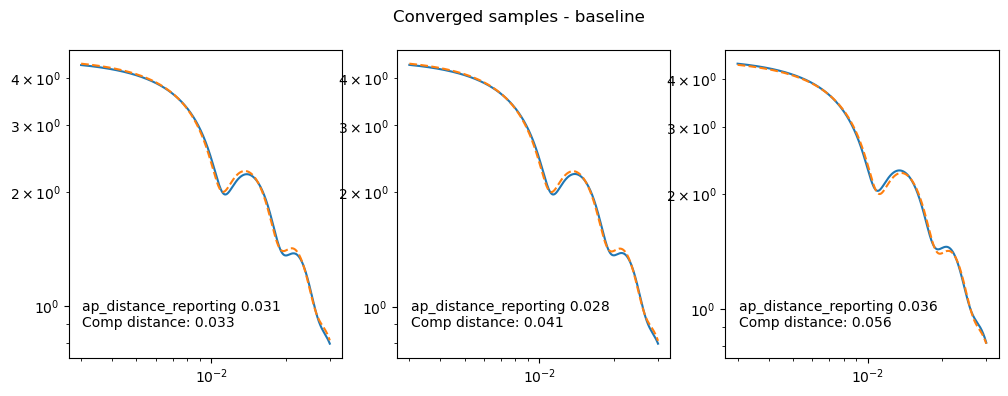

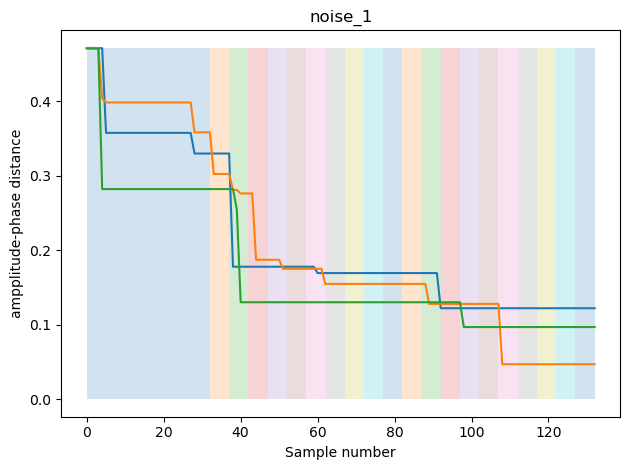

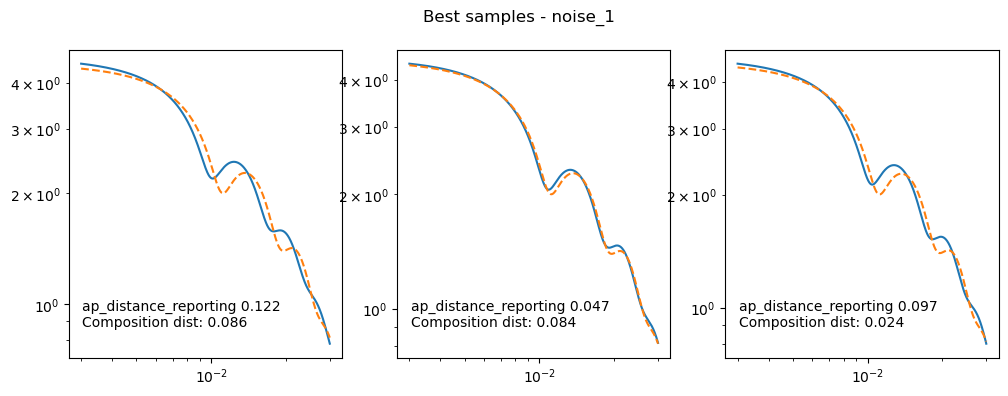

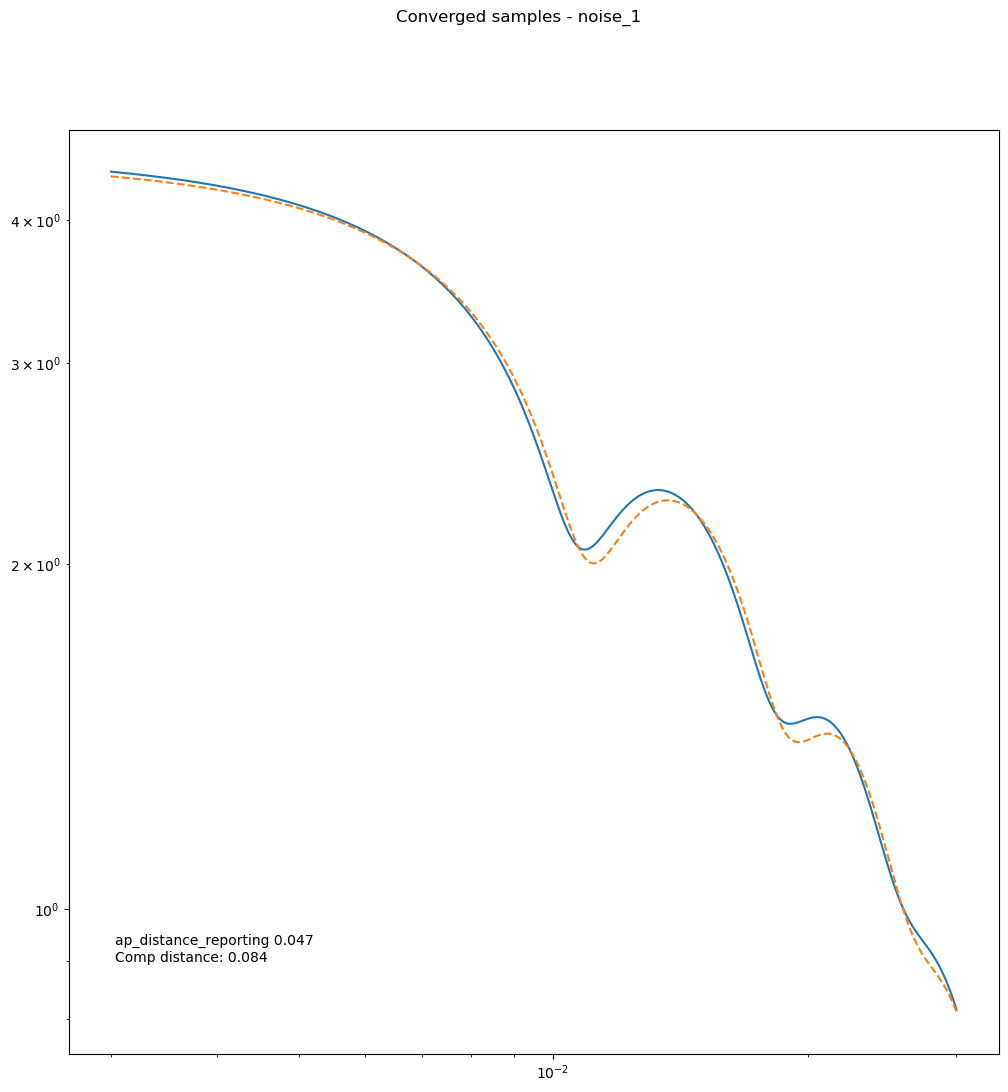

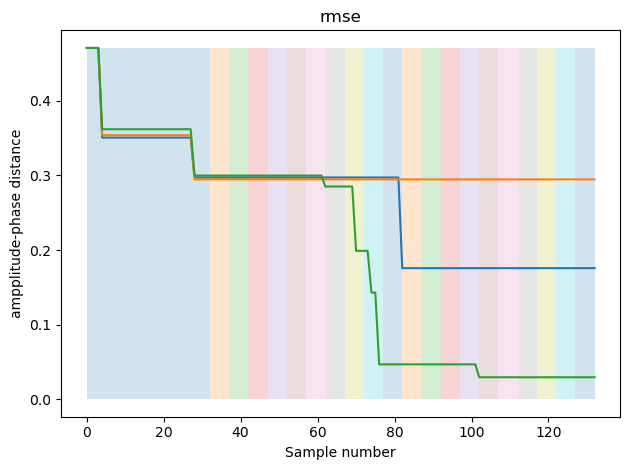

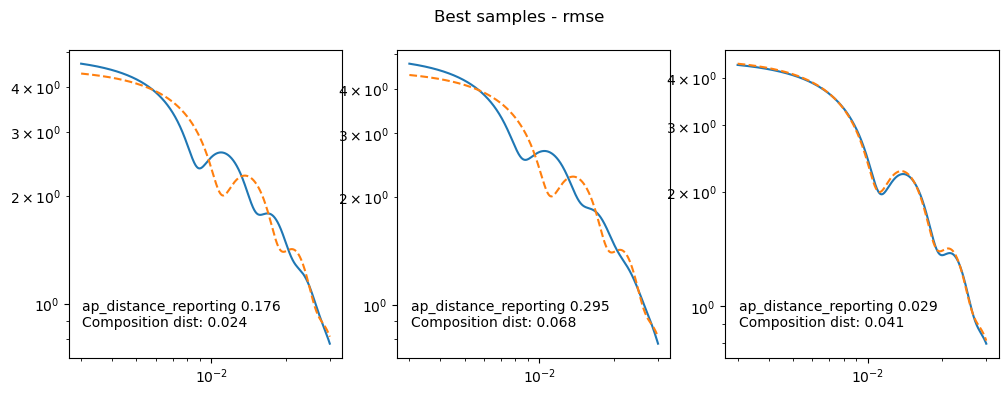

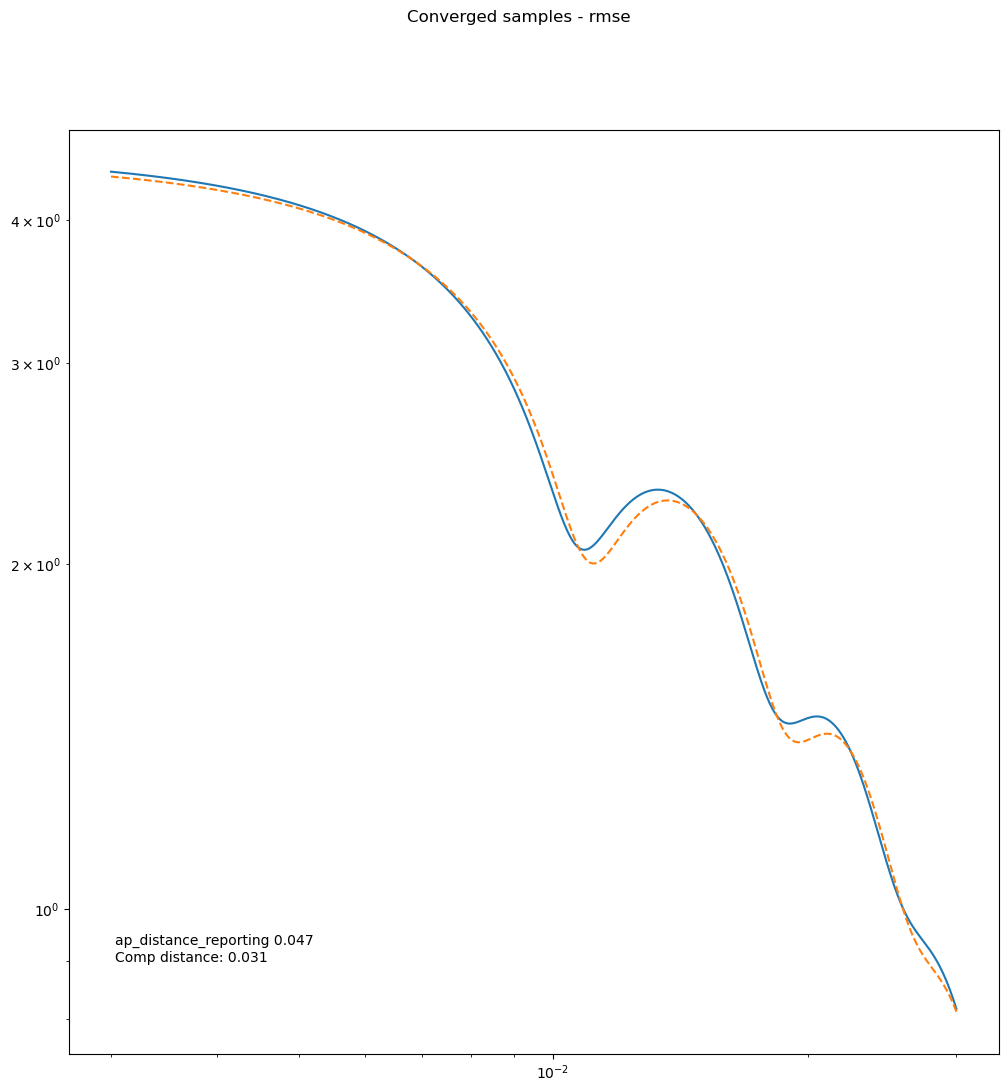

In [14]:
convergence_threshold = 0.05
n_replicates = 3
budget = 40

#contour plot things
n_grid = 50
with open('../TEOS_water_ammoniaOptima_gridvals_80nm_ogfuncs_50.npy', 'rb') as f:
    Z_ammonia = np.load(f)

with open('../TEOS_ammonia_waterOptima_gridvals_80nm_ogfuncs_50.npy', 'rb') as f:
    Z_water = np.load(f)


best_distance_results = {}
for trial_name, params in trials.items():


    if trial_name == 'DLS':
        params['distance'] = 'DLS'

    batch_size = params['batch_size']
    m_samples = params['m_samples']

    if batch_size == 0:
        n_batches = 0
    else:
        n_batches = int(np.ceil(budget/batch_size))

        
    os.mkdir(trial_name)
    data_complete, data_batches, best_distances_list, best_uuids_list, converge_iterations, converge_uuid, best_composition_dist, name_bounds = post_process.process_distances(trial_name, params, true_min, n_replicates = n_replicates, convergence_threshold = convergence_threshold)
    fig = post_process.convergence_plot(data_complete, best_distances_list, best_uuids_list, name_bounds, trial_name)
    plt.savefig(f'{trial_name}/convergence_plot_{trial_name}.png', dpi = 300)
    best_scat = post_process.best_scatterer_plots(data_complete, best_uuids_list, q_grid_nonlog, target_I, trial_name, true_min)
    plt.savefig(f'{trial_name}/best_scatterer_plot_{trial_name}.png', dpi = 300)
    converge_scat = post_process.converge_scatterer_plots(data_complete, converge_uuid, q_grid_nonlog, target_I, trial_name, true_min)
    plt.savefig(f'{trial_name}/converged_scatterer_plots_{trial_name}.png', dpi = 300)

    best_distance_results[trial_name] = best_distances_list
    nanconverged = []
    for el in converge_iterations:
        if el == 'Not converged':
            el = 132
        nanconverged.append(el)
    mean_converge = np.nanmean(nanconverged) 

    print('########################')
    print(f'Results for {trial_name}')
    print(f'Iterations to convergence (threshold {convergence_threshold}): {converge_iterations}, mean: {mean_converge}')
    print(f'Closest composition distances observed: {best_composition_dist}')

    lower_bounds = params['lower_bounds']
    upper_bounds = params['upper_bounds']
    
    ammonia = np.linspace(lower_bounds[1], upper_bounds[1], n_grid)
    water = np.linspace(lower_bounds[2], upper_bounds[2], n_grid)
    teos = np.linspace(lower_bounds[0], upper_bounds[0], n_grid)
    for i in range(n_replicates):
        phased = post_process.phase_diagram(data_batches[i], params['lower_bounds'], params['upper_bounds'], q_grid, f'{trial_name}_replicate_{i}')
        plt.savefig(f'{trial_name}/{trial_name}_replicate_{i}.png', dpi = 300)#

        anim = contour_animated.ContourAnimation(ammonia, water, teos, Z_ammonia, Z_water, 
                                data_batches[i], best_uuids_list[i], n_batches, true_min, trial_name, n_grid, m_samples, batch_size)
        
        anim.save(f"{trial_name}/{trial_name}_replicate_{i}.html", format="html")  # Saves as an HTML file

    # consider convergence on optimizaiton metric used
    data_complete, data_batches, best_distances_list_optim, best_uuids_list_optim, converge_iterations_optim, converge_uuid_optim, best_composition_dist_optim, name_bounds = post_process.process_distances(trial_name, params, true_min, dist_name = 'distance', n_replicates = n_replicates, convergence_threshold = convergence_threshold)
    fig = post_process.convergence_plot(data_complete, best_distances_list_optim, best_uuids_list_optim, name_bounds, trial_name, ylabel = params['distance'])
    plt.savefig(f'{trial_name}/convergence_plot_optimdistance_{trial_name}.png', dpi = 300)
    best_scat = post_process.best_scatterer_plots(data_complete, best_uuids_list_optim, q_grid_nonlog, target_I, trial_name, true_min, distance = 'distance')
    plt.savefig(f'{trial_name}/best_scatterer_plot_optimdistance_{trial_name}.png', dpi = 300)
    converge_scat = post_process.converge_scatterer_plots(data_complete, converge_uuid_optim, q_grid_nonlog, target_I, trial_name, true_min, distance = 'distance')
    plt.savefig(f'{trial_name}/converged_scatterer_plots_optimdistance_{trial_name}.png', dpi = 300)

    

## PLot AP-distance vs rmse

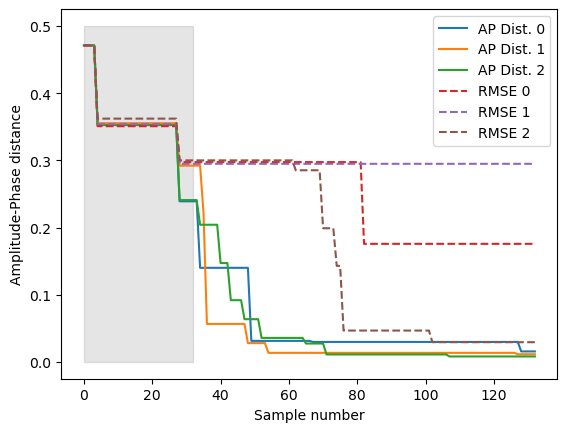

In [26]:
fig, ax = plt.subplots()

ax.fill_between((0, 32), 0, 0.5, color = 'k', alpha = 0.1)

for i in range(3):
    ax.plot(best_distance_results['baseline'][i], label = f'AP Dist. {i}')

for i in range(3):
    ax.plot(best_distance_results['rmse'][i], label = f'RMSE {i}', ls = '--')

ax.legend()
ax.set_xlabel('Sample number')
ax.set_ylabel('Amplitude-Phase distance')
plt.savefig('apdist_vs_rmse.png', dpi = 300)

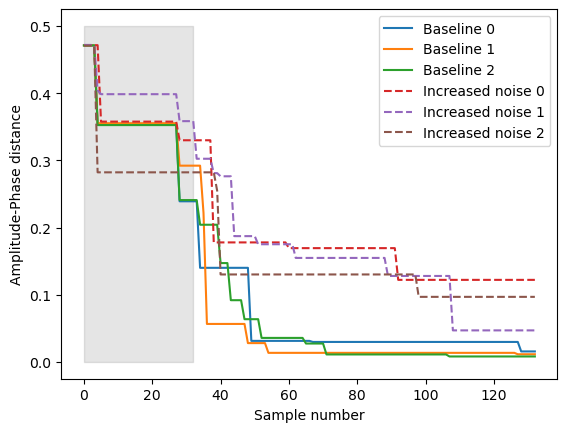

In [28]:
fig, ax = plt.subplots()

ax.fill_between((0, 32), 0, 0.5, color = 'k', alpha = 0.1)

for i in range(3):
    ax.plot(best_distance_results['baseline'][i], label = f'Baseline {i}')

for i in range(3):
    ax.plot(best_distance_results['noise_1'][i], label = f'Increased noise {i}', ls = '--')

ax.legend()
ax.set_xlabel('Sample number')
ax.set_ylabel('Amplitude-Phase distance')
plt.savefig('baseline_vs_noise.png', dpi = 300)

In [29]:
best_uuids_list[0][-1]

'9feeff72-be3a-47d7-a68b-7650b353c25e'

In [30]:
data_complete[best_uuids_list[0][-1]]

{'teos_vol_frac': tensor(0.0050),
 'ammonia_vol_frac': tensor(0.0364),
 'water_vol_frac': tensor(0.0529),
 'scattering_I': array([1.72635626e+04, 1.72426154e+04, 1.72215942e+04, ...,
        6.53215624e+00, 6.47057304e+00, 6.41106072e+00]),
 'real_sampled_point': [0.00494227677742429,
  0.03635916975170492,
  0.05287895384020315],
 'diameter': 70.52492578916006,
 'pdi': 0.10676978567347895,
 'distance': 0.11336437054542822,
 'ap_distance_reporting': 0.12431730139614042,
 'I_scaled': array([4.13887179, 4.13834451, 4.13781472, ..., 0.71679793, 0.71268411,
        0.70867126])}

In [31]:
data_complete[best_uuids_list_optim[0][-1]]

{'teos_vol_frac': tensor(0.0050),
 'ammonia_vol_frac': tensor(0.0050),
 'water_vol_frac': tensor(0.1023),
 'scattering_I': array([1.93686780e+04, 1.93424964e+04, 1.93162256e+04, ...,
        6.60532926e+00, 6.55502785e+00, 6.50536909e+00]),
 'real_sampled_point': [0.004664541756094381,
  0.005168576185192195,
  0.10225867986089755],
 'diameter': 73.24172995875007,
 'pdi': 0.11999226759982462,
 'distance': 0.09602280556388633,
 'ap_distance_reporting': 0.17328658445389278,
 'I_scaled': array([4.22485336, 4.22426591, 4.22367565, ..., 0.75764785, 0.75432792,
        0.75102532])}

In [36]:
data_complete[converge_uuid_optim[0]]

{'teos_vol_frac': tensor(0.0050),
 'ammonia_vol_frac': tensor(0.0050),
 'water_vol_frac': tensor(0.1081),
 'scattering_I': array([2.21402702e+04, 2.21066299e+04, 2.20728803e+04, ...,
        6.48815277e+00, 6.43575287e+00, 6.38338674e+00]),
 'real_sampled_point': [0.004860018945528304,
  0.004740938499087278,
  0.1080277543416744],
 'diameter': 77.43409280315959,
 'pdi': 0.12078203439882096,
 'distance': 0.04964849036327561,
 'ap_distance_reporting': 0.1672764863108714,
 'I_scaled': array([4.32242834, 4.32176796, 4.32110443, ..., 0.78936649, 0.78584478,
        0.78229658])}

['b9c6e392-84cf-4026-8cd8-c55aa7f11261',
 '40d0304e-e0dd-4f71-b771-153f4b843ac9']

In [34]:
converge_uuid

['833efcbd-0bd7-47f8-8f2d-85d2682b6f94']